# Voyages API Use Cases

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
pip install signal-ocean

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Voyages API Use Cases


In [2]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

### Get voyages

In [4]:
vlcc_id = 84
date_from = date.today() - timedelta(days=180)

In [5]:
voyages = api.get_voyages(vessel_class_id=vlcc_id, date_from=date_from)

In [6]:
voyages = pd.DataFrame(v.__dict__ for v in voyages)
events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)
historical_events = events[events['event_horizon']=='Historical']

In [7]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)

In [8]:
def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

In [9]:
def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)

### Number of exporting voyages 

In [10]:
voyages_exports_usg = voyages[(voyages['load_area']=='US Gulf')&(voyages['discharge_country']!='United States')]

In [11]:
voyages_exports_usg.shape[0]

86

In [12]:
voyages_exports_usg['discharge_country'].value_counts()

Korea, Republic of    32
India                 21
China                 14
Taiwan                10
Singapore              5
Thailand               3
Malaysia               1
Name: discharge_country, dtype: int64

### Port Delays

In [13]:
discharges_china = historical_events[(historical_events['country']=='China')&(historical_events['purpose']=='Discharge')].copy()
discharges_china['duration'] =  discharges_china['sailing_date'] - discharges_china['arrival_date']

In [14]:
discharges_china['duration'].describe()

count                          502
mean     6 days 17:33:52.400760956
std      7 days 03:28:37.457735556
min                0 days 02:06:19
25%         3 days 00:01:15.250000
50%                4 days 08:00:19
75%         7 days 00:06:48.750000
max               79 days 15:54:45
Name: duration, dtype: object

In [15]:
discharges_china['duration_in_hours'] = discharges_china['duration'] / np.timedelta64(1, 'h')

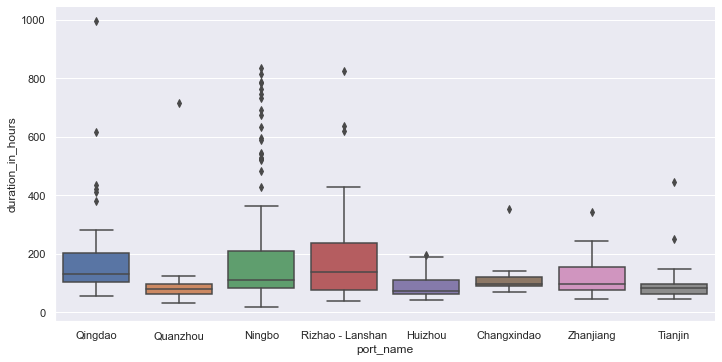

In [16]:
common_discharge_ports_china = discharges_china['port_name'].value_counts().head(8)
common_port_discharges_china = discharges_china[discharges_china['port_name'].isin(common_discharge_ports_china.index)]
sns.catplot(x="port_name", y="duration_in_hours", kind="box", data=common_port_discharges_china, aspect=2);

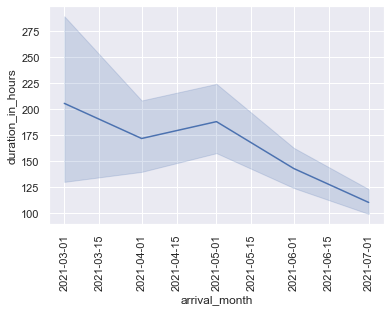

In [17]:
discharges_china['arrival_month'] = discharges_china['arrival_date'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()
sns.lineplot(data=discharges_china, x='arrival_month', y='duration_in_hours')
plt.xticks(rotation=90);

### Discharge destinations

In [18]:
discharge_destinations_brazil = voyages[voyages['load_country']=='Brazil'].dropna(subset=['discharge_country'])

In [19]:
discharge_destinations_brazil['discharge_country'].value_counts()

China                 46
Korea, Republic of     5
India                  4
Singapore              3
Japan                  1
Name: discharge_country, dtype: int64

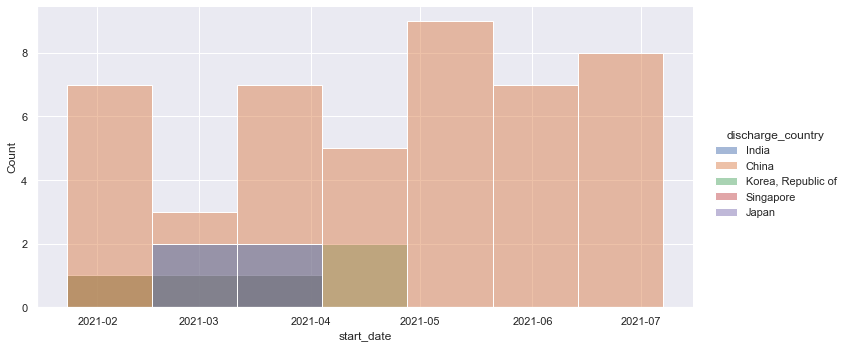

In [20]:
sns.displot(discharge_destinations_brazil, x="start_date", hue="discharge_country", aspect=2);

### Advanced Voyage Search: Discharge origins

This use-case demonstrates how to utilise the advanced search endpoint to extract historical voyages by **vessel_class_id**, **first_load_arrival_date** and a specific **event_purpose**. The voyages with the provided purpose can then be merged and filtered with a specific *load_area* and *discharge_country* in order to visualize the vessel flows into the specified country.

In [21]:
vlcc_id = 84
date_from = date.today() - timedelta(days=60)
load_area = 'Arabian Gulf'
discharge_country = 'Japan'

In [22]:
voyages_load_events = api.get_voyages_by_advanced_search(vessel_class_id=vlcc_id, first_load_arrival_date_from=date_from,
                                                    event_horizon='Historical', event_purpose='Load')

voyages_discharge_events = api.get_voyages_by_advanced_search(vessel_class_id=vlcc_id, first_load_arrival_date_from=date_from,
                                                    event_horizon='Historical', event_purpose='Discharge')

In [23]:
voyages_load_events = pd.DataFrame(v.__dict__ for v in voyages_load_events)
voyages_discharge_events = pd.DataFrame(v.__dict__ for v in voyages_discharge_events)

In [24]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages_load_events['load_area'] = voyages_load_events['events'].apply(get_voyage_load_area)
voyages_load_events['load_country'] = voyages_load_events['events'].apply(get_voyage_load_country)
voyages_discharge_events['discharge_country'] = voyages_discharge_events['events'].apply(get_voyage_discharge_country)

In [25]:
voyages_events_merged = voyages_load_events.merge(voyages_discharge_events[['id','discharge_country']], on='id', how='inner')

In [26]:
voyages_filtered = voyages_events_merged.loc[(voyages_events_merged['load_area'] == load_area) & (voyages_events_merged['discharge_country'] == discharge_country)].reset_index(drop=True)

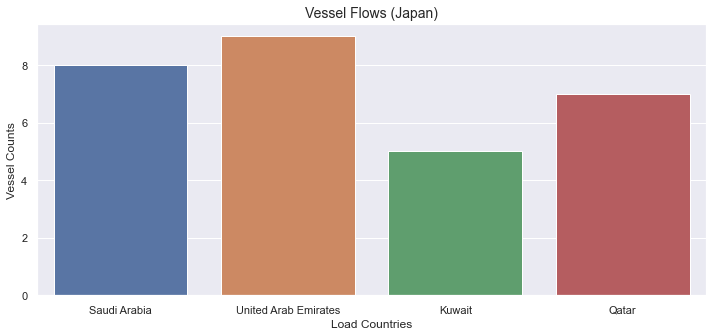

In [27]:
plt.rcParams["figure.figsize"] = (12,5)
ax = sns.countplot(x='load_country', data=voyages_filtered)

ax.set_title(f'Vessel Flows ({discharge_country})', fontsize=14)
ax.set_xlabel('Load Countries', fontsize=12)
ax.set_ylabel('Vessel Counts', fontsize=12);